### **Decision Tree Project Tutorial**

#### **Predicting Diabetes**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

**Data Dictionary**:

- *Pregnancies:* Number of times pregnant
- *Glucose:* Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- *BloodPressure:* Diastolic blood pressure (mm Hg)
- *SkinThickness:* Triceps skin fold thickness (mm)
- *Insulin:* 2-Hour serum insulin (mu U/ml)
- *BMI:* Body mass index (weight in kg/(height in m)^2)
- *DiabetesPedigreeFunction:* Diabetes pedigree function
- *Age:* Age (years)
- *Outcome:* Class variable (0 or 1), Class Distribution: (class value 1 is interpreted as "tested positive for diabetes")

**Importar librerías y cargar dataset**

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
df = pd.read_csv(url)

**Primeras observaciones**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
461,1,71,62,0,0,21.8,0.416,26,0
425,4,184,78,39,277,37.0,0.264,31,1
94,2,142,82,18,64,24.7,0.761,21,0
651,1,117,60,23,106,33.8,0.466,27,0


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Llama la atención la existencia de valores altos en Pregnancies.

No debería ser válido tener valores 0 en Glucose, BloodPressure, SkinThickness, Insulin ni BMI.

Los valores mínimos y máximos de edad parecen correctos.

In [6]:
columnas = list(df.columns.values)
columnas.remove('Pregnancies')
columnas.remove('Outcome')

for columna in columnas:
    print(f'Hay {len(df[df[columna]==0])} entradas con valor 0 en {columna}')

Hay 5 entradas con valor 0 en Glucose
Hay 35 entradas con valor 0 en BloodPressure
Hay 227 entradas con valor 0 en SkinThickness
Hay 374 entradas con valor 0 en Insulin
Hay 11 entradas con valor 0 en BMI
Hay 0 entradas con valor 0 en DiabetesPedigreeFunction
Hay 0 entradas con valor 0 en Age


In [7]:
df.value_counts('Outcome')

Outcome
0    500
1    268
dtype: int64

No hay valores nulos ni fuera de lo esperado en Outcome.

El dataset no está balanceado.

**Dividir el dataset en train y test**

In [8]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

In [10]:
df_train = pd.concat([X_train, y_train], axis=1)

In [11]:
df_test = pd.concat([X_test, y_test], axis=1)

**Scatterplots e histogramas**

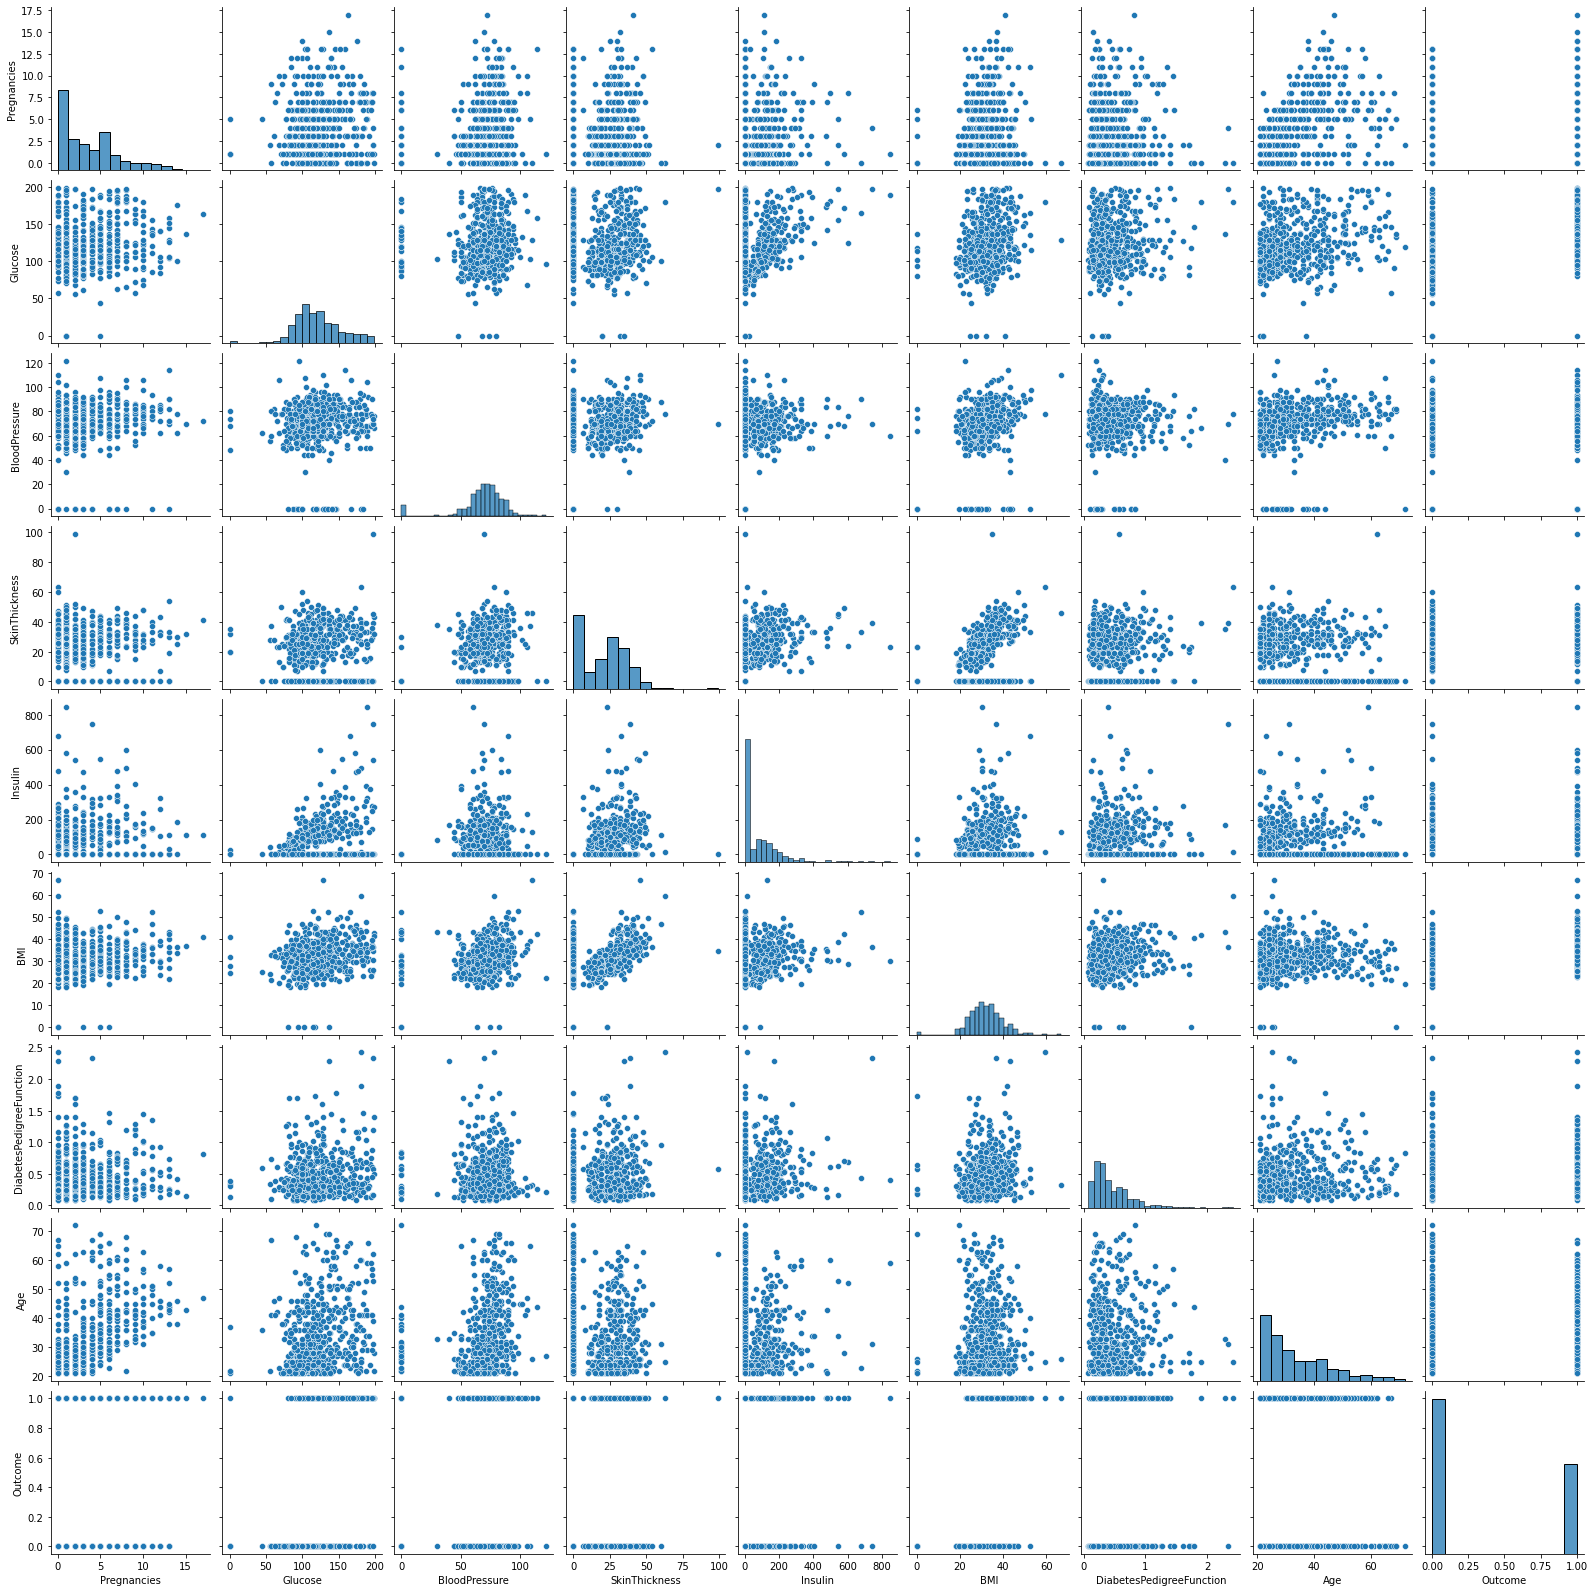

In [12]:
sns.pairplot(df_train)
plt.show()

**Boxplots**

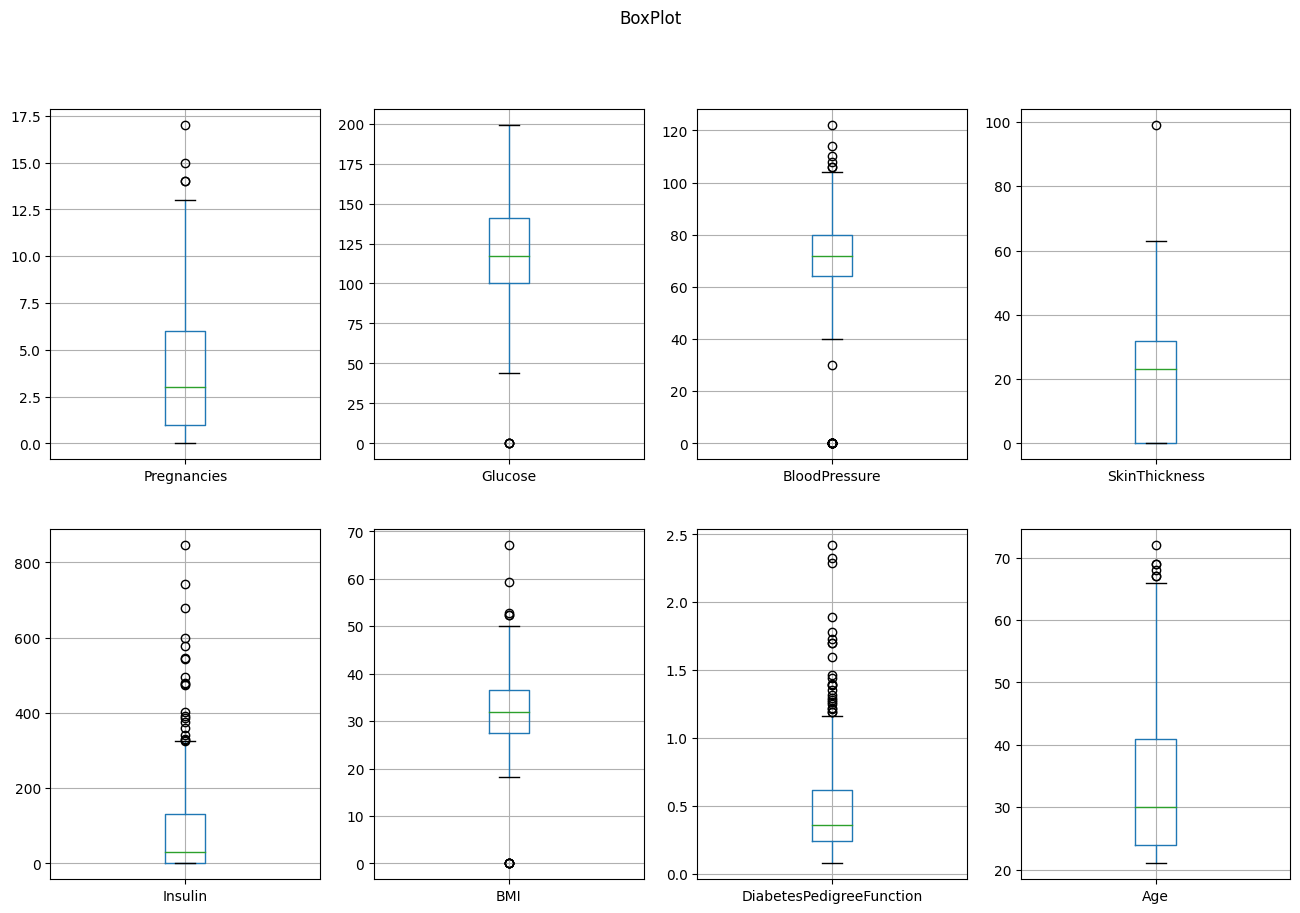

In [13]:
fig, ax = plt.subplots(2, 4, figsize=(16, 10))
axs = ax.flatten()
for i in range(8):
    X_train.iloc[:, i].to_frame().boxplot(ax=axs[i])
plt.suptitle("BoxPlot")
plt.show()

**Sustituir valores 0 por la media de la columna** (sin incluir ceros al calcular la media)

In [14]:
def sustituir_ceros(df, columna):

    media = df[columna][df[columna]>0].mean()

    def sustituir_valor(valor):
        if valor == 0:
            return media
        else:
            return valor
    
    df[columna] = df[columna].apply(sustituir_valor)

In [15]:
for columna in columnas:
    sustituir_ceros(df_train, columna)

X_train = df_train.drop(columns=['Outcome'])
y_train = df_train['Outcome']
df_train = pd.concat([X_train, y_train], axis=1)

En principio la sustitución de valores debería hacerse únicamente en el dataset de entrenamiento. Sin embargo en este caso los valores 0 son erróneos (ya que por ejemplo es imposible que una persona tenga BMI=0), y por lo tanto considero que deberían tratarse como si fueran valores faltantes. Por este motivo también hago la sustitución por la media en el dataset de prueba.

In [16]:
for columna in columnas:
    sustituir_ceros(df_test, columna)

X_test = df_test.drop(columns=['Outcome'])
y_test = df_test['Outcome']
df_test = pd.concat([X_test, y_test], axis=1)

**Análisis de outliers**

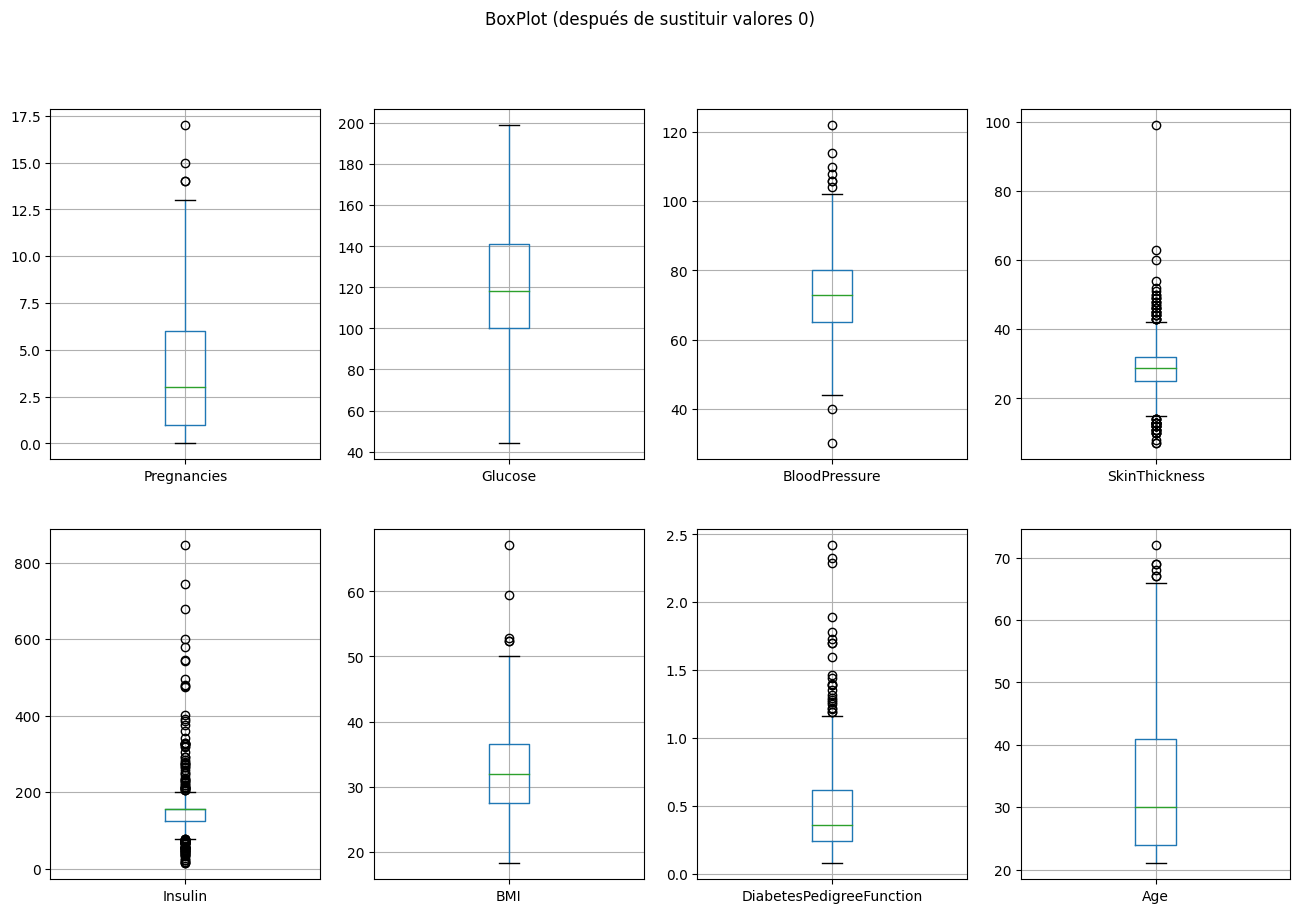

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(16, 10))
axs = ax.flatten()
for i in range(8):
    X_train.iloc[:, i].to_frame().boxplot(ax=axs[i])
plt.suptitle("BoxPlot (después de sustituir valores 0)")
plt.show()

In [18]:
def limites_outliers(columna):
    q1 = X_train[columna].quantile(0.25)
    q3 = X_train[columna].quantile(0.75)
    IQR = q3 - q1
    min_so = q1 - 1.5*IQR
    max_so = q3 + 1.5*IQR
    return [min_so, max_so]

In [19]:
def print_proporcion_altos(columna):
    lim = limites_outliers(columna)
    df_altos = df_train[df_train[columna]>lim[1]]
    if len(df_altos)>0:
        dict_altos = dict(df_altos.value_counts('Outcome'))
        if len(dict_altos)>1:
            print(f'El {(dict_altos[1]*100)/(dict_altos[1]+dict_altos[0]) :.1f}% de los outliers mayores a la cota superior de la columna {columna} corresponden a Outcome=1')
        else:
            print(f'El 100% de los outliers mayores a la cota superior de la columna {columna} corresponden a Outcome=1')
    else:
        print(f'La columna {columna} no tiene outliers por encima de la cota superior')

In [20]:
def print_proporcion_bajos(columna):
    lim = limites_outliers(columna)
    df_bajos = df_train[df_train[columna]<lim[0]]
    if len(df_bajos)>0:
        dict_bajos = dict(df_bajos.value_counts('Outcome'))
        if len(dict_bajos)>1:
            print(f'El {(dict_bajos[1]*100)/(dict_bajos[1]+dict_bajos[0]) :.1f}% de los outliers menores a la cota inferior de la columna {columna} corresponden a Outcome=1')
        else:
            print(f'El 100% de los outliers menores a la cota inferior de la columna {columna} corresponden a Outcome=1')
    else:
        print(f'La columna {columna} no tiene outliers por debajo de la cota superior')

In [21]:
for columna in columnas:
    print_proporcion_altos(columna)

train_values = dict(df_train.value_counts('Outcome'))
print()
print(f'En comparación, el {(train_values[1]*100)/(train_values[1]+train_values[0]) :.1f}% de las filas en el dataset de entrenamiento corresponden a Outcome=1')

La columna Glucose no tiene outliers por encima de la cota superior
El 57.1% de los outliers mayores a la cota superior de la columna BloodPressure corresponden a Outcome=1
El 50.0% de los outliers mayores a la cota superior de la columna SkinThickness corresponden a Outcome=1
El 59.3% de los outliers mayores a la cota superior de la columna Insulin corresponden a Outcome=1
El 80.0% de los outliers mayores a la cota superior de la columna BMI corresponden a Outcome=1
El 54.2% de los outliers mayores a la cota superior de la columna DiabetesPedigreeFunction corresponden a Outcome=1
El 16.7% de los outliers mayores a la cota superior de la columna Age corresponden a Outcome=1

En comparación, el 36.7% de las filas en el dataset de entrenamiento corresponden a Outcome=1


Los outliers con valores altos en general tienen mayor proporción de personas diabéticas, por lo tanto eliminarlos contribuiría a desbalancear aún más el dataset.

La excepción es Age. 

En el caso de Age, considero que no es necesario eliminar estos outliers ya que corresponden a edades válidas.

In [22]:
for columna in columnas:
    print_proporcion_bajos(columna)

train_values = df_train.value_counts('Outcome')
print()
print(f'En comparación, el {(train_values[1]*100)/(train_values[1]+train_values[0]) :.1f}% de las filas en el dataset de entrenamiento corresponden a Outcome=1')

La columna Glucose no tiene outliers por debajo de la cota superior
El 50.0% de los outliers menores a la cota inferior de la columna BloodPressure corresponden a Outcome=1
El 16.1% de los outliers menores a la cota inferior de la columna SkinThickness corresponden a Outcome=1
El 9.4% de los outliers menores a la cota inferior de la columna Insulin corresponden a Outcome=1
La columna BMI no tiene outliers por debajo de la cota superior
La columna DiabetesPedigreeFunction no tiene outliers por debajo de la cota superior
La columna Age no tiene outliers por debajo de la cota superior

En comparación, el 36.7% de las filas en el dataset de entrenamiento corresponden a Outcome=1


Los outliers con valores bajos en general tienen baja proporción de personas diabéticas, por lo tanto eliminarlos no contribuiría a desbalancear el dataset.

La excepción es BloodPressure.

- Eliminar valores altos de Pregnancies
- Eliminar valores bajos de SkinThickness e Insulin

In [23]:
limites_preg = limites_outliers('Pregnancies')
limites_ST = limites_outliers('SkinThickness')
limites_insulin = limites_outliers('Insulin')

In [24]:
df_train = df_train.drop(df_train[df_train['Pregnancies']>limites_preg[1]].index)
df_train = df_train.drop(df_train[df_train['SkinThickness']<limites_ST[0]].index)
df_train = df_train.drop(df_train[df_train['Insulin']<limites_insulin[0]].index)

In [25]:
X_train = df_train.drop(columns=['Outcome'])
y_train = df_train['Outcome']
df_train = pd.concat([X_train, y_train], axis=1)

**Correlación entre las variables**

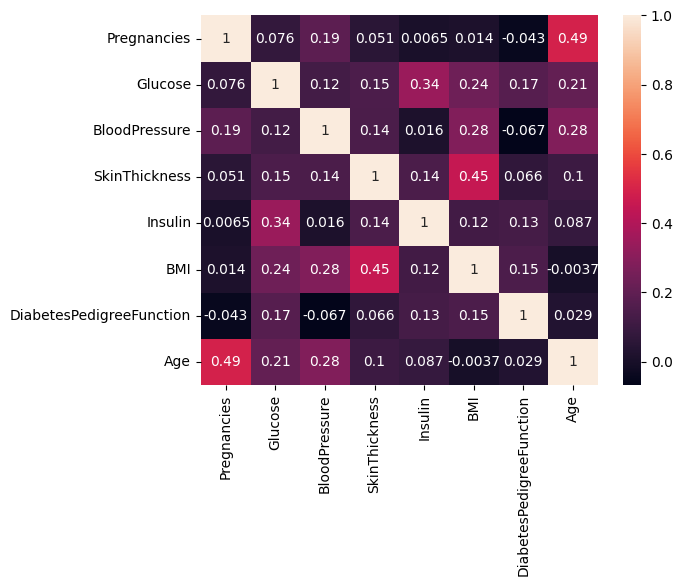

In [26]:
sns.heatmap(X_train.corr(),annot=True)
plt.show()

Las correlación más alta se da entre Age y Pregnancies, SkinThickness y BMI, Glucose e Insulin.

En ningún caso la correlación es tan alta como para considerar eliminar una de las columnas.

**Construcción y evaluación del modelo**

In [27]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [28]:
y_pred = dtc.predict(X_test)

In [52]:
print(f'Accuracy: {dtc.score(X_test, y_test) : .2f}')

Accuracy:  0.71


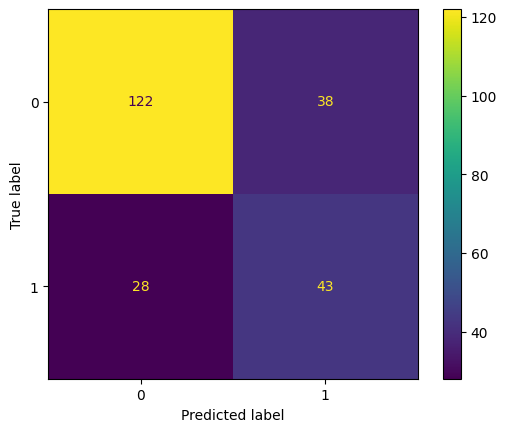

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dtc.classes_)
disp.plot()

plt.show()

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79       160
           1       0.53      0.61      0.57        71

    accuracy                           0.71       231
   macro avg       0.67      0.68      0.68       231
weighted avg       0.73      0.71      0.72       231



**Construcción y evaluación del modelo usando entropy como criterio**

In [32]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=0)

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [33]:
y_pred_ent = clf.predict(X_test)

In [51]:
print(f'Accuracy: {clf.score(X_test, y_test) : .2f}')

Accuracy:  0.68


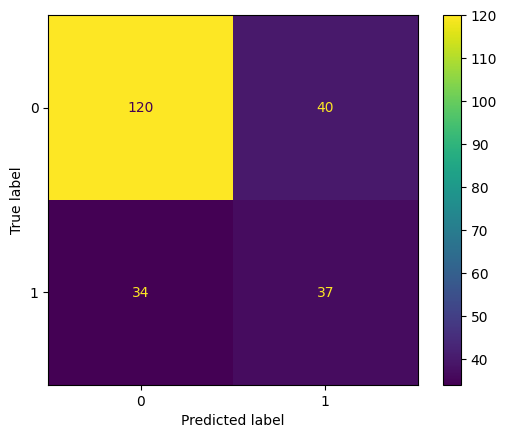

In [35]:
conf_matrix_ent = confusion_matrix(y_test, y_pred_ent, labels=clf.classes_)
disp_ent = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ent, display_labels=clf.classes_)
disp_ent.plot()

plt.show()

In [36]:
print(classification_report(y_test, y_pred_ent))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       160
           1       0.48      0.52      0.50        71

    accuracy                           0.68       231
   macro avg       0.63      0.64      0.63       231
weighted avg       0.69      0.68      0.68       231



**Usar GridSearch para encontrar los mejores hiperparámetros**

In [42]:
modelo = DecisionTreeClassifier()
criterios = ['gini','entropy']
max_depth = [4, 5, 6, 9, 10, 12, 15, 20, 30]
min_samples_split = [2, 3, 4]

grid_dict = dict(criterion=criterios, max_depth=max_depth, min_samples_split=min_samples_split)

grid_search = GridSearchCV(modelo, grid_dict, cv=4)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 9, 10, 12, 15, 20, 30],
                         'min_samples_split': [2, 3, 4]})

In [43]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(max_depth=5, min_samples_split=4)


**Construcción y evaluación del modelo usando los hiperparámetros encontrados**

In [44]:
modelo_hp = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=4)

modelo_hp.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=4)

In [45]:
y_pred_hp = modelo_hp.predict(X_test)

In [48]:
print(f'Accuracy: {modelo_hp.score(X_test, y_test) : .2f}')

Accuracy:  0.75


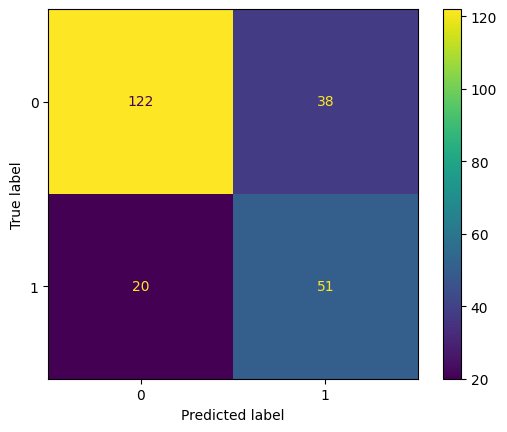

In [49]:
conf_matrix_hp = confusion_matrix(y_test, y_pred_hp, labels=modelo_hp.classes_)
disp_hp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_hp, display_labels=modelo_hp.classes_)
disp_hp.plot()

plt.show()

In [50]:
print(classification_report(y_test, y_pred_hp))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       160
           1       0.57      0.72      0.64        71

    accuracy                           0.75       231
   macro avg       0.72      0.74      0.72       231
weighted avg       0.77      0.75      0.76       231

